# Estimate Sobol’ indices for the Ishigami function by a sampling method: a quick start guide to sensitivity analysis

### Analyse de la fonction Ishigami avec l'ensemble de codes dévelopés pour l'analyse de sensibilité sur les cahmps stochastiques.

#### Comparaison et corréctions

La même logique d'écriture de codes est utilisée que dans le script 'Demo Analyse de sensibilité poutre'

In [13]:
# Voici les deux scripts destinés à gérer l'analyse de sensibilité sur les champs stochastiques
import NdGaussianProcessSensitivity as ngps
import NdGaussianProcessConstructor as ngpc
import NdGaussianProcessSensitivityIndices as ngpsi
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
import matplotlib.pyplot            as plt
from   importlib                import reload 


In [55]:
# This is the formula used in the openTURNS example. 
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

# we have to modifiy the function, be cause it takes as an input a random vector, un-correlated
# in the case of our method, un-correlated inputs are clearly distinct. 

def gMod(X1,X2,X3):
    X = np.stack([X1,X2,X3]).T
    print(X.shape)
    return g(X)

In [56]:
X = np.random.uniform(-np.pi,np.pi,[10,3])
assert gMod(X[...,0], X[...,1], X[...,2]) == g(X) ,""

(10, 3)


Maintenant nous définissons nos variables d'entrée, avec les fonctions contenues dans notre méthode 

In [57]:
reload(ngpc)
reload(ngps)
lower  = -np.pi
upper  = np.pi
nameX1 = 'X1'
nameX2 = 'X2'
nameX3 = 'X3'
RV_X1 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX1)
RV_X2 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX2)
RV_X3 = ngpc.UniformDistribution(lower = lower, upper = upper, name = nameX3)

In [58]:
# here we have to explicitely define our outputs
outputVariables = {'out1_name' :  #any name here is fine
                   {
                         'name'     : 'Y',
                         'position' : 0,
                         'shape'    : (1,)  
                    },
                  }

In [59]:
inputList    = [RV_X1, RV_X2, RV_X3]
soloFunction = sampleFunction = gMod
size         = 10000

In [60]:
processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

Input Variables are (without Karhunen Loeve Decomposition) :
 ['X1', 'X2', 'X3'] 

Output Variables are :
 ['Y'] 



In [61]:
processSensitivityAnalysis.prepareSobolIndicesExperiment()

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)
number of samples for sobol experiment =  50000 

input design is:  [[-0.17150988  1.79973094 -2.83650555]
 [ 0.78254569 -0.34495171 -0.9861231 ]
 [ 0.24259852  0.46400209 -1.69350245]
 ...
 [-0.88614745 -2.98655426 -0.398084  ]
 [-0.94475993 -1.47029432  2.76851141]
 [-0.67015169  0.14382418 -2.28565296]]


In [62]:
processSensitivityAnalysis.getOutputDesignAndPostprocess()

(50000, 3)
Converting list of outputs into matrix: 
Element  1  has shape  (50000, 1)
Final shape matrix:  (50000, 1)
Columns where nan :  [] 


No errors while processing, the function has returned no np.nan.



In [63]:
output = processSensitivityAnalysis.outputDesignList; output1 = output[0]; 

In [30]:
### Calcul à la main pour comparer

# Préparation échantillons
output1
A  = output1[0:1000,...]
B  = output1[1000:2000,...]
E1 = output1[2000:3000,...]
Ac = A-A.mean(axis=0)
Bc = B-B.mean(axis=0)
Ec = E1-E1.mean(axis=0)

# préparation du vecteur mu =(X,Y)
X = np.squeeze(np.multiply(Ec,Bc))
Y = np.squeeze(np.square(Ac))
# covariance gamma = covXY
covXY = np.cov(X,Y)
#fonction psi symbolique 
psifo,psito = ngpsi.NdGaussianProcessSensitivityIndicesBase.SymbolicSaltelliIndices(1)
#vecteur g 'à la main', censé être égal à psi(mu)
g = [1/A.std()**2, -1*(0.24491474/A.std()**2)]   ### Ici S = 0.24491474 

meanPsi = np.squeeze(psifo.gradient((X.mean(),Y.mean())))
meanPsi2 = (1/Y.mean(),-1*(X.mean()/(Y.mean()**2)))
print('les valeurs avec psi symoblique ou analytique sont identiques.\nsymbolique:',meanPsi,'\nanalytique:',meanPsi2)
print('mais avec g :',g,'différent qu avec psi' )
u = np.squeeze(np.matmul(covXY,meanPsi))
var = np.matmul(meanPsi.T, u)/1000
var2 = np.matmul(g,np.matmul(covXY,g))/1000
print('var psi=',round(var,5),'var g=',round(var2,5))

les valeurs avec psi symoblique ou analytique sont identiques.
symbolique: [ 0.06750703 -0.01837072] 
analytique: (0.06750702551564336, -0.018370723873928966)
mais avec g : [0.06750702551564336, -0.01653346560233716] différent qu avec psi
var psi= 0.00093 var g= 0.0009


In [66]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 5)
import NdGaussianProcessSensitivityIndices as ngpsi
_=reload(ngpsi)

Populating the interactive namespace from numpy and matplotlib


In [64]:
S, Stot, varS, varStot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output1, 10000)

There are 3 indices to get in (1,) dimensions with 1 elements
After centering, mean= [2.78312276] 
std=  [3.95277647]
After centering, mean= [2.0939382] 
std=  [4.07563003]
After centering, mean= [1.39456246] 
std=  [4.07491114]
After centering, mean= [0.70566188] 
std=  [3.95964979]
After centering, mean= [-1.60866875e-16] 
std=  [3.69959345]
basic output shape is: (10000, 1)
output reshaped into matrix of shape (dim<=2)  [10000, 1]
data for variance calculus prepared 
 X_fo shape is (10000,) Y_fo shape is (10000,) 

Covariance is: [[191.43577643  42.81819819]
 [ 42.81819819 484.44321473]]
Sample mean is: [4.21465828895676, 13.738440346902987]
Psi mean is: [ 0.07278847 -0.02232994]
variance is: 0.00011166234237384774 

Covariance is: [[316.46959555 111.26441733]
 [111.26441733 484.44321473]]
Sample mean is: [6.087506095679232, 13.738440346902987]
Psi mean is: [-0.07278847  0.03225259]
variance is: 0.0001658226525705671 

basic output shape is: (10000, 1)
output reshaped into matrix of

The output is scalar
The sensitivity is measured accordingly to the 3 input variables, namely:
 X1 and X2 and X3


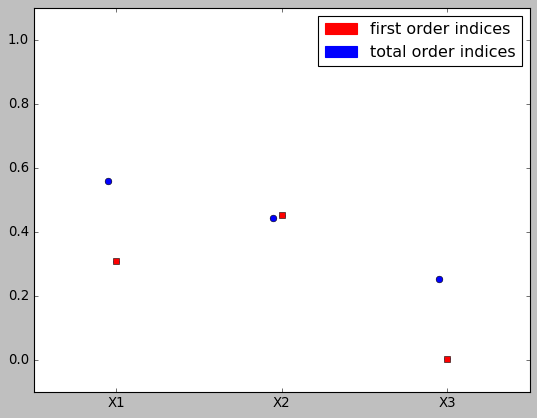

In [65]:
varNames = ['X1', 'X2', 'X3']
ngpsi.plotSobolIndicesWithErr(S, varS, varNames, 3, Stot, varStot)

In [66]:
varS

array([[0.00011166],
       [0.00013982],
       [0.0001805 ]])

In [67]:
S


array([[0.30677851],
       [0.45017905],
       [0.00264426]])

In [68]:
dist = ot.ComposedDistribution([ot.Uniform(-np.pi, np.pi)] * 3)

In [69]:
sal = ot.SaltelliSensitivityAlgorithm(dist, 10000, g, False)

In [73]:
sal.getFirstOrderIndicesDistribution().getCovariance()

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[9.9847e-05,3.13825e-05,1.02781e-05,3.13825e-05,0.000147405,2.04022e-05,1.02781e-05,2.04022e-05,0.000157695]

In [75]:
sal.getFirstOrderIndicesDistribution().computeBilateralConfidenceInterval(0.95)

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[0.281529,0.401588,-0.0293527] upper bound=class=Point name=Unnamed dimension=3 values=[0.327033,0.455103,0.0290027] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

In [71]:
sal.getFirstOrderIndices()

class=Point name=Unnamed dimension=3 values=[0.304457,0.430233,-0.00160679]

In [78]:
0.304457 + ot.Normal().computeQuantile(0.975)[0]*9.9847e-5**0.5

0.32404164038142763